In [3]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# --- Step 1: Load the new feature-engineered dataset ---
df_new = pd.read_csv(r"C:\My stuff\Coding\ML project\KiranveerSingh_projectfinal\Notebook\Model_robusting\cleaned_featured_HDFC.csv")  # Replace with your new dataset path

# --- Step 2: Prepare features and target ---
exclude_cols = ['Date', 'Symbol', 'Will_Grow']
# All candidate features
all_features = [col for col in df_new.columns if col not in exclude_cols]

# Separate numeric and categorical features (assumes categorical are non-numeric)
numeric_features = df_new[all_features].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = list(set(all_features) - set(numeric_features))

X_new_num = df_new[numeric_features].copy()
X_new_cat = df_new[categorical_features].copy()

# --- Step 3: One-hot encode categorical features ---
X_new_cat_enc = pd.get_dummies(X_new_cat, drop_first=True)

# --- Step 4: Load saved categorical columns from training to align ---
try:
    train_cat_cols = joblib.load("models/X_train_cat_enc_columns.pkl")
    # Reindex to match train categorical dummy columns
    X_new_cat_enc = X_new_cat_enc.reindex(columns=train_cat_cols, fill_value=0)
except FileNotFoundError:
    print("Warning: categorical columns list not found, using current encoding columns as-is.")

# --- Step 5: Combine numeric and categorical features ---
X_new = pd.concat([X_new_num.reset_index(drop=True), X_new_cat_enc.reset_index(drop=True)], axis=1)

# --- Step 6: Rename columns to match scaler's expected feature names ---

# Load scaler
scaler = joblib.load(r"C:\My stuff\Coding\ML project\KiranveerSingh_projectfinal\Models\scaler.pkl")

# Check scaler feature names if available (scikit-learn >= 1.0)
if hasattr(scaler, 'feature_names_in_'):
    scaler_features = list(scaler.feature_names_in_)
    print("Scaler expects feature names:")
    print(scaler_features)

    # Find mismatches between expected scaler columns and X_new columns
    # Sometimes underscores vs spaces cause mismatch, so create a mapping:
    rename_map = {}
    for feat in scaler_features:
        # Try to find match ignoring underscore/space differences
        normalized_feat = feat.replace(" ", "_").lower()
        matched_cols = [col for col in X_new.columns if col.lower() == normalized_feat]
        if matched_cols:
            rename_map[matched_cols[0]] = feat

    # Rename X_new columns to scaler expected names
    X_new = X_new.rename(columns=rename_map)

    # Ensure X_new columns exactly match scaler features and same order
    X_new = X_new.reindex(columns=scaler_features)

else:
    print("Scaler does not store feature names, please ensure feature order matches.")

# --- Step 7: Apply scaler to numeric features only ---
# Get numeric features expected by scaler (those in scaler_features that are numeric)
scaler_numeric_features = [f for f in scaler.get_feature_names_out() if f in numeric_features or f in scaler_features]

# For safety, but most critical is to apply scaler to columns it expects
X_new[scaler_features] = scaler.transform(X_new[scaler_features])

# --- Step 8: Load saved model ---
model = joblib.load(r"C:\My stuff\Coding\ML project\KiranveerSingh_projectfinal\Models\XGBoost.pkl")  # Replace with your model path

# --- Step 9: Predict and evaluate ---

y_true = df_new['Will_Grow']

y_pred = model.predict(X_new)
if hasattr(model, "predict_proba"):
    y_prob = model.predict_proba(X_new)[:, 1]
else:
    y_prob = y_pred  # fallback

print("Robustness Evaluation on New Dataset:")

print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
print(f"F1-score:  {f1_score(y_true, y_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_true, y_prob):.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Scaler expects feature names:
['Prev Close', 'Open', 'High', 'Low', 'Last', 'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume', '%Deliverble', 'SMA_5', 'SMA_10', 'SMA_20', 'Return_1D', 'Volatility_10', 'High_Low_Ratio', 'Open_Close_Ratio', 'Volume_SMA_10', 'Volume_Ratio', 'Close_Lag_1', 'Volume_Lag_1', 'Close_Lag_2', 'Volume_Lag_2', 'Close_Lag_3', 'Volume_Lag_3', 'RSI_14']
Robustness Evaluation on New Dataset:
Accuracy:  0.4918
Precision: 0.5097
Recall:    0.2512
F1-score:  0.3365
ROC-AUC:   0.5014

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.75      0.59      1186
           1       0.51      0.25      0.34      1250

    accuracy                           0.49      2436
   macro avg       0.50      0.50      0.46      2436
weighted avg       0.50      0.49      0.46      2436


Confusion Matrix:
[[884 302]
 [936 314]]


Robustness Evaluation Metrics:
Accuracy : 0.4918
Precision: 0.5097
Recall   : 0.2512
F1-score : 0.3365
ROC-AUC  : 0.5014

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.75      0.59      1186
           1       0.51      0.25      0.34      1250

    accuracy                           0.49      2436
   macro avg       0.50      0.50      0.46      2436
weighted avg       0.50      0.49      0.46      2436


Confusion Matrix:
          Pred 0  Pred 1
Actual 0     884     302
Actual 1     936     314


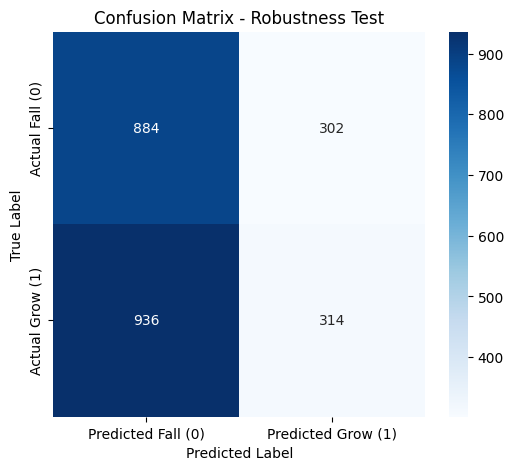

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)

# Replace below with your actual arrays from your model evaluation step:
# Example:
y_true = df_new['Will_Grow']  # True values from your new dataset
y_pred = model.predict(X_new)  # Predicted labels for new dataset
y_prob = model.predict_proba(X_new)[:, 1]  # Predicted probabilities

# Assuming y_true, y_pred, y_prob already defined, e.g., from:
y_true = df_new['Will_Grow']
y_pred = model.predict(X_new)
y_prob = model.predict_proba(X_new)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_prob) if 'y_prob' in locals() else None

print("Robustness Evaluation Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
if roc_auc is not None:
    print(f"ROC-AUC  : {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Pred 0', 'Pred 1'])
print("\nConfusion Matrix:")
print(cm_df)

plt.figure(figsize=(6,5))
plt.title("Confusion Matrix - Robustness Test")
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Fall (0)", "Predicted Grow (1)"],
            yticklabels=["Actual Fall (0)", "Actual Grow (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
